# randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples
Andrew E. Davidson  
aedaivds@ucsc.edu
31/31/24

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

This notebook is a copy of ../lungCancer/randomForestIntraCellularLungCancerBiomarkersOnExtracellularSamples.ipynb 

I wanted to quickly see if this method works on Elife Esophagus Cancer

ref : 
- [testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb](testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb)
- deconvolutionAnalysis/jupyterNotebooks/hyperParameterTunning/hyperparameterTunningResults5.ipynb see cell [16]

TODO AEDWIP

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

# import joblib
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import pprint as pp
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    

meaningOfLife = 42

/data/tmp/ipykernel_2800919/1484917113.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/esophagusCancer/../../../../deconvolutionAnalysi

In [3]:
# import local 
from analysis.utilities import findFile
from intraExtraRNA.elifeUtilities import loadElifeTrainingData

In [4]:
%%time
# quick test to see if there is preliminary evidence this could work
# Esophagus_Mucosa specificity = 0.996, sensitivity = 0.991
# deconvolutionAnalysis/jupyterNotebooks/hyperParameterTunning/hyperparameterTunningResults5.ipynb
pipelineStageName = "best10CuratedDegree1_ce467ff"
features = ["Esophagus_Mucosa"]
selectElifeCategories = ["Healthy donor", "Esophagus Cancer"]
HUGO_EMGenes, elifeLungGenes, countDF, metaDF, XNP, yNP = loadElifeTrainingData(pipelineStageName,
                                                                                     features,
                                                                                     selectElifeCategories,
                                                                                     )


print(f'XNP.shape : {XNP.shape} yNP.shape : {yNP.shape} number of Healthy Control : {np.sum(yNP)}')
print(f'HUGO_EMGenes\n{HUGO_EMGenes}')
metaDF.groupby("diagnosis").count()

2024-04-04 19:37:06,587 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:177] [len(elifeLungGenes) : 10]
2024-04-04 19:37:06,588 WARNING intraExtraRNA.elifeUtilities loadElifeTrainingData() line:178] [missingElifeGenes
 : ['ENSG00000180667.10', 'ENSG00000082269.16', 'ENSG00000148429.14']]


refSeq2ENSGDF.loc[selectRows, :] :
           HUGO                ENSG                  bioType
17274      YOD1  ENSG00000180667.10           protein_coding
77061   FAM135A  ENSG00000082269.16     processed_transcript
77062   FAM135A  ENSG00000082269.16           protein_coding
77071   FAM135A  ENSG00000082269.16  nonsense_mediated_decay
77073   FAM135A  ENSG00000082269.16          retained_intron
110892   USP6NL  ENSG00000148429.14           protein_coding
110895   USP6NL  ENSG00000148429.14     processed_transcript
XNP.shape : (74, 7) yNP.shape : (74,) number of Healthy Control : 43
HUGO_EMGenes
['FAM135A', 'YOD1', 'THOC3', 'USP6NL', 'NLRX1', 'TXNDC17', 'PGM2', 'DHRS1', 'TTC7B', 'PLD2']
CPU times: user 21.2 s, sys: 2.69 s, total: 23.9 s
Wall time: 23.9 s


,sample_id
diagnosis,
Colorectal Cancer,53
Esophagus Cancer,31
Healthy donor,43
Liver Cancer,26
Lung Cancer,35
Stomach Cancer,36


In [5]:
# https://stackoverflow.com/a/64540588/4586180
# The specifity is basically the True Negative Rate which is the same as the True Positive Rate (Recall)
# but for the negative class
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
specificity = make_scorer(recall_score, pos_label=0)

scoringMetricsDict = {
    'accuracy' : 'accuracy', # TP
    'sensitivity' : 'recall',
    'specificity' : specificity,
    #'f1' : 'f1'
}    

# Train Random Forest Classifier
Goal: get a rough idea how to use Random Forest

In [6]:
%%time

def testDefault():
    model = RandomForestClassifier()
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html
    crossValidationGenerator = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=meaningOfLife)
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #  true positive rate = sensitivity = recall = tp / (tp + fn)
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
    #  precision = tp / (tp + fp)
    
    
    scoringMetricsDict = {
        'accuracy' : 'accuracy', # TP
        'sensitivity' : 'recall',
        'specificity' : specificity
    }
        
    scoresDict = cross_validate(model, XNP, yNP, scoring=scoringMetricsDict, cv=crossValidationGenerator, n_jobs=-1)
    
    # report performance
    for key in scoringMetricsDict.keys():
        scores = scoresDict["test_" + key]
        print(f'Mean {key}: %.3f std {key} :%.3f' % (np.mean(scores), np.std(scores)))

testDefault()
print()

Mean accuracy: 0.573 std accuracy :0.164
Mean sensitivity: 0.677 std sensitivity :0.226
Mean specificity: 0.422 std specificity :0.245

CPU times: user 212 ms, sys: 5.68 s, total: 5.89 s
Wall time: 8.73 s


# Hyperparmeter Tunning

**max_samples** : the number of samples to draw from X to train each base estimator.
```
0 <= int max_samples : <= 1
```

**<span style="color:red;background-color:yellow">This is a hacky POC see extraCellularRNA/intraExtraRNA_POC/python/srcmodels/randomForestHyperparmeterSearch.py**  


In [7]:
def evaluateModel(model, XNP, yNP, scoringMetricsDict) -> dict:
    # define the evaluation procedure
    # crossValidationGenerator = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=meaningOfLife)
    crossValidationGenerator = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=meaningOfLife)
    
    # evaluate the model and collect the results
    scoresDict = cross_validate(model, XNP, yNP, scoring=scoringMetricsDict, cv=crossValidationGenerator, n_jobs=-1)
    
    return scoresDict

In [8]:
def createMaxSampleModels():
    models = dict()
    # explore ratios from 10% to 100% in 10% increments
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        # set max_samples=None to use 100%
        if i == 1.0:
            i = None
        models[key] = RandomForestClassifier(max_samples=i)
    
    return models

In [9]:
%%time
def tunningFramework(parameterName: str, 
                     modelDict : dict,
                    XNP : np.array, 
                    yNP : np.array, 
                    scoringMetricsDict : dict) -> dict:
    # maxSampleModelsDict = createMaxSampleModels()
    
 
    resultsDict = dict()
    for key in scoringMetricsDict.keys():
        resultsDict[key] = {}
        
    # for hyperparameterValue, model in maxSampleModelsDict.items():
    for hyperparameterValue, model in modelDict.items():
        scoresDict = evaluateModel(model, XNP, yNP, scoringMetricsDict)
        #print(f'\n\n*********scoresDict\n{pp.pformat(scoresDict, indent=4)}\n')
        for metricName in scoringMetricsDict.keys():
            scoreKey = "test_" + metricName
            #print(f'hyperparameterValue: {hyperparameterValue} metricName : {metricName} scoreKey: {scoreKey}')
            values = scoresDict[scoreKey]
            #print(np.round(values, decimals=3))
            resultsDict[metricName][hyperparameterValue] =  values

            print(f'{parameterName}={hyperparameterValue} {metricName}\tmean : %.3f std : %.3f)' % ( np.mean(values), np.std(values)))
        print()
            
        #print(f'scores.keys\n {scores.keys()}')
    return resultsDict

# print(resultsDict.keys())
# resultsDict

maxSampleModelsDict = createMaxSampleModels()
maxSampleResultsDict = tunningFramework(parameterName='max_samples', 
                               modelDict=maxSampleModelsDict,
                              XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

max_samples=0.1 accuracy	mean : 0.554 std : 0.066)
max_samples=0.1 sensitivity	mean : 0.856 std : 0.124)
max_samples=0.1 specificity	mean : 0.133 std : 0.194)

max_samples=0.2 accuracy	mean : 0.579 std : 0.099)
max_samples=0.2 sensitivity	mean : 0.814 std : 0.125)
max_samples=0.2 specificity	mean : 0.262 std : 0.203)

max_samples=0.3 accuracy	mean : 0.566 std : 0.124)
max_samples=0.3 sensitivity	mean : 0.742 std : 0.059)
max_samples=0.3 specificity	mean : 0.333 std : 0.211)

max_samples=0.4 accuracy	mean : 0.592 std : 0.087)
max_samples=0.4 sensitivity	mean : 0.742 std : 0.127)
max_samples=0.4 specificity	mean : 0.386 std : 0.068)

max_samples=0.5 accuracy	mean : 0.604 std : 0.161)
max_samples=0.5 sensitivity	mean : 0.739 std : 0.188)
max_samples=0.5 specificity	mean : 0.419 std : 0.167)

max_samples=0.6 accuracy	mean : 0.661 std : 0.130)
max_samples=0.6 sensitivity	mean : 0.839 std : 0.117)
max_samples=0.6 specificity	mean : 0.414 std : 0.180)

max_samples=0.7 accuracy	mean : 0.633 st

In [10]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=True)
# fs = 10  # fontsize

# labels = resultsDict['sensitivity'].keys()
# values = resultsDict['sensitivity'].values()
# axs[0, 0].boxplot(values, labels=labels)
# axs[0, 0].set_title('sensitivity', fontsize=fs)

# labels = resultsDict['specificity'].keys()
# values = resultsDict['specificity'].values()
# axs[0, 1].boxplot(values, labels=labels)
# axs[0, 1].set_title('specificity', fontsize=fs)

# # axs[0, 2].boxplot(data, labels=labels)
# # axs[0, 2].set_title('Default', fontsize=fs)

saved image to /private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out/img/max_samples.png


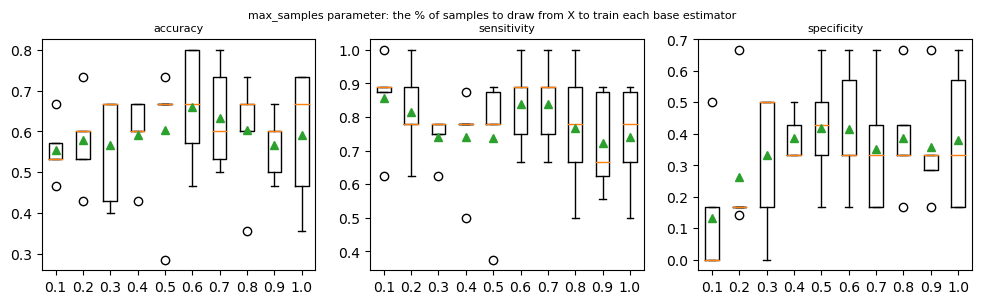

In [11]:
def plotFramework(resultsDict : dict,
                  scoringMetricsDict : dict, 
                  title : str) -> tuple[plt.figure, list[plt.axes]] :
    
    scoringMetricNames = list(scoringMetricsDict.keys())
    numMetrics = len(scoringMetricNames)
    fs = 8  # fontsize
    w = 12
    h = 3
    fig, axs = plt.subplots(nrows=1, ncols=numMetrics, figsize=(w, h), ) #sharey=True
    for i in range(0, numMetrics):
        metricName = scoringMetricNames[i]
        panel = axs[i]
        labels = resultsDict[metricName].keys()
        values = resultsDict[metricName].values()
        panel.boxplot(values, labels=labels, showmeans=True)
        # panel.set_title('max_samples' + " " + metricName, fontsize=fs)
        panel.set_title( metricName, fontsize=fs)
    
    fig.suptitle(title, fontsize=fs)
    return (fig, axs)

title='max_samples parameter: the % of samples to draw from X to train each base estimator'
fig, axs = plotFramework(maxSampleResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/max_samples.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

**max_features** : defaults to the square root of the number of input features

max_features=1 accuracy	mean : 0.565 std : 0.115)
max_features=1 sensitivity	mean : 0.717 std : 0.189)
max_features=1 specificity	mean : 0.357 std : 0.166)

max_features=2 accuracy	mean : 0.565 std : 0.115)
max_features=2 sensitivity	mean : 0.719 std : 0.146)
max_features=2 specificity	mean : 0.357 std : 0.166)

max_features=3 accuracy	mean : 0.538 std : 0.111)
max_features=3 sensitivity	mean : 0.647 std : 0.143)
max_features=3 specificity	mean : 0.386 std : 0.164)

max_features=4 accuracy	mean : 0.565 std : 0.107)
max_features=4 sensitivity	mean : 0.669 std : 0.182)
max_features=4 specificity	mean : 0.419 std : 0.167)

saved image to /private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out/img/max_features.png
CPU times: user 1.38 s, sys: 109 ms, total: 1.49 s
Wall time: 5.41 s


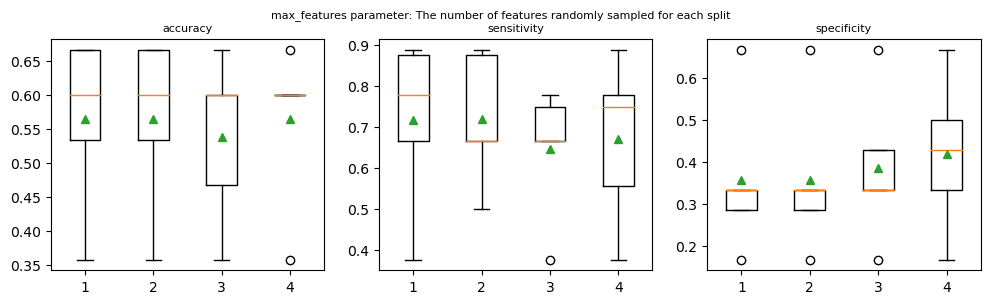

In [12]:
%%time
def createMaxFeaturesModels(XNP : np.array, bound : int) -> dict:
    nFeatures = XNP.shape[1]
    medianNFeatures = int( nFeatures**0.5 )
    start = medianNFeatures - bound
    if start < 1:
        start = 1
    end = medianNFeatures + bound
    
    modelDict = dict()
    for i in np.arange(start, end, 1):
        key = str(i)
        modelDict[key] = RandomForestClassifier(max_features=i)
    
    return modelDict

maxFeaturesModelDict = createMaxFeaturesModels(XNP, bound=3)

maxFeaturesResultsDict = tunningFramework(parameterName='max_features', 
                               modelDict=maxFeaturesModelDict,
                              XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

title='max_features parameter: The number of features randomly sampled for each split'
fig, axs = plotFramework(maxFeaturesResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/max_features.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

**n_estimators** : The number of trees. Default 100

Increase number of trees till model performance stablizes.

Intuition might suggest
that more trees will lead to overfitting, although this is not the case. Both bagging and random
forest algorithms appear to be somewhat immune to overfitting the training dataset given the
stochastic nature of the learning algorithm.

n_estimators=50 accuracy	mean : 0.537 std : 0.133)
n_estimators=50 sensitivity	mean : 0.647 std : 0.143)
n_estimators=50 specificity	mean : 0.386 std : 0.164)

n_estimators=100 accuracy	mean : 0.550 std : 0.141)
n_estimators=100 sensitivity	mean : 0.647 std : 0.174)
n_estimators=100 specificity	mean : 0.414 std : 0.180)

n_estimators=500 accuracy	mean : 0.579 std : 0.108)
n_estimators=500 sensitivity	mean : 0.744 std : 0.113)
n_estimators=500 specificity	mean : 0.352 std : 0.187)

n_estimators=1000 accuracy	mean : 0.566 std : 0.100)
n_estimators=1000 sensitivity	mean : 0.722 std : 0.135)
n_estimators=1000 specificity	mean : 0.352 std : 0.187)

n_estimators=1500 accuracy	mean : 0.566 std : 0.100)
n_estimators=1500 sensitivity	mean : 0.722 std : 0.135)
n_estimators=1500 specificity	mean : 0.352 std : 0.187)

n_estimators=2000 accuracy	mean : 0.551 std : 0.122)
n_estimators=2000 sensitivity	mean : 0.697 std : 0.160)
n_estimators=2000 specificity	mean : 0.352 std : 0.187)

saved image to /

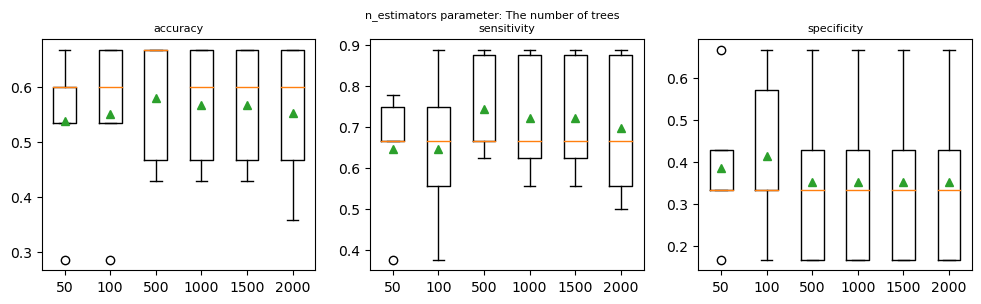

In [13]:
%%time
def createNumEstimatorsModels() -> dict:
    modelDict = dict()
    for i in [50, 100, 500, 1000, 1500, 2000]:
        key = str(i)
        modelDict[key] = RandomForestClassifier(n_estimators=i)
    
    return modelDict

numEstimatorModelDict = createNumEstimatorsModels()
numEstimatorResultsDict = tunningFramework(parameterName='n_estimators', 
                                         modelDict=numEstimatorModelDict,
                                          XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

title='n_estimators parameter: The number of trees'
fig, axs = plotFramework(numEstimatorResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/numTrees.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

**max_depth** : tree depth

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

max_depth=1 accuracy	mean : 0.512 std : 0.059)
max_depth=1 sensitivity	mean : 0.839 std : 0.094)
max_depth=1 specificity	mean : 0.067 std : 0.133)

max_depth=2 accuracy	mean : 0.579 std : 0.108)
max_depth=2 sensitivity	mean : 0.833 std : 0.126)
max_depth=2 specificity	mean : 0.229 std : 0.136)

max_depth=3 accuracy	mean : 0.566 std : 0.100)
max_depth=3 sensitivity	mean : 0.767 std : 0.200)
max_depth=3 specificity	mean : 0.295 std : 0.198)

max_depth=4 accuracy	mean : 0.551 std : 0.129)
max_depth=4 sensitivity	mean : 0.697 std : 0.160)
max_depth=4 specificity	mean : 0.348 std : 0.224)

max_depth=5 accuracy	mean : 0.619 std : 0.104)
max_depth=5 sensitivity	mean : 0.789 std : 0.094)
max_depth=5 specificity	mean : 0.386 std : 0.164)

max_depth=6 accuracy	mean : 0.538 std : 0.111)
max_depth=6 sensitivity	mean : 0.719 std : 0.146)
max_depth=6 specificity	mean : 0.290 std : 0.194)

max_depth=7 accuracy	mean : 0.565 std : 0.136)
max_depth=7 sensitivity	mean : 0.722 std : 0.192)
max_depth=7 spe

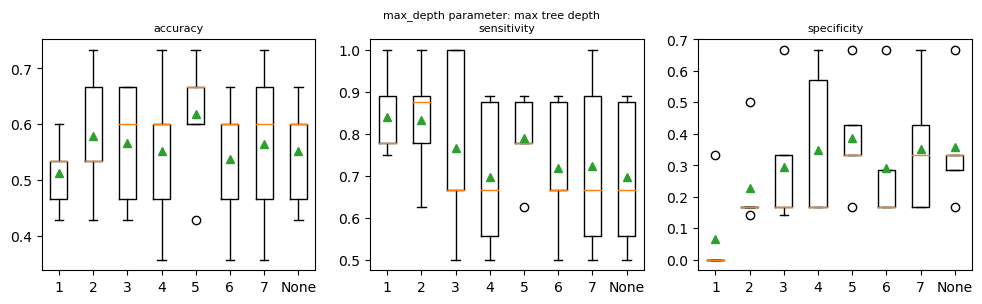

In [14]:
%%time
def createMaxDepthsModels() -> dict:
    modelDict = dict()
    depths = [i for i in range(1,8)] + [None]
    for i in depths:
        key = str(i)
        modelDict[key] = RandomForestClassifier(max_depth=i)
    
    return modelDict

maxDepthModelDict = createMaxDepthsModels()
maxDepthResultsDict = tunningFramework(parameterName='max_depth', 
                                         modelDict=maxDepthModelDict,
                                          XNP=XNP, yNP=yNP, scoringMetricsDict=scoringMetricsDict)

title='max_depth parameter: max tree depth'
fig, axs = plotFramework(maxDepthResultsDict, scoringMetricsDict, title)

imgFilePath = imgOut + "/max_depth.png"
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saved image to {imgFilePath}')

# <span style="background-color:yellow;color:red">Review Hyperparmeter tunning</span>
04/03/2024 :output from extraCellularRNA/intraExtraRNA_POC/bin/randomForestHyperparmeterEsophagus_MucosaSearch.sh
- k-fold with 3 repeats and 5 splits to estimate the skill of model
- grid search 3169 points across hyper parameters (max_features,max_samples,n_estimators,max_depth).
- reported mean, and std for accuracy, specificity and sensitivity

In [15]:
modelOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out"
outFile = "randomForestHyperparmeterSearch.csv"
fpath = modelOut + "/" + outFile

print(f'fpath:\n {fpath}')
rfhpDF = pd.read_csv(fpath)

print(f'rfhpDF.shape : {rfhpDF.shape}')
rfhpDF.head()

fpath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv
rfhpDF.shape : (3168, 10)


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,max_features,max_samples,n_estimators,max_depth
0,0.580952,0.026255,1.0,0.0,0.000000,0.000000,1.0,0.1,2000.0,1.0
1,0.580952,0.026255,1.0,0.0,0.000000,0.000000,1.0,0.2,500.0,1.0
2,0.580952,0.026255,1.0,0.0,0.000000,0.000000,1.0,0.1,1500.0,1.0
3,0.580952,0.026255,1.0,0.0,0.000000,0.000000,1.0,0.3,500.0,1.0
4,0.594286,0.043685,1.0,0.0,0.033333,0.066667,1.0,0.6,50.0,1.0


In [16]:
threshold = 0.5 #0.7
cols = ['sensitivity_mean', 'specificity_mean', 'max_features',	'max_samples', 'n_estimators',	'max_depth']

In [17]:
selectHighSensitivityRows = rfhpDF.loc[:, "sensitivity_mean"] >= threshold
highSensitivityDF = rfhpDF.loc[selectHighSensitivityRows, cols].sort_values(by="sensitivity_mean", ascending=False)
print(f'highSensitivityDF.shape : {highSensitivityDF.shape}')
highSensitivityDF.head()

highSensitivityDF.shape : (3168, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
0,1.0,0.000000,1.0,0.1,2000.0,1.0
8,1.0,0.000000,1.0,0.1,500.0,1.0
1,1.0,0.000000,1.0,0.2,500.0,1.0
13,1.0,0.033333,2.0,0.1,100.0,1.0
11,1.0,0.000000,1.0,0.2,2000.0,1.0


In [18]:
selectHighSpecificityRows = rfhpDF.loc[:, "specificity_mean"] >= threshold
highSpecificityDF = rfhpDF.loc[selectHighSpecificityRows, cols].sort_values(by="specificity_mean", ascending=False)
print(f'highSpecificityDF.shape : {highSpecificityDF.shape}')
highSpecificityDF.head()

highSpecificityDF.shape : (7, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
2209,0.719444,0.519048,4.0,0.4,50.0,5.0
2263,0.719444,0.519048,4.0,0.6,50.0,NaN
1117,0.791667,0.514286,3.0,0.7,50.0,3.0
1945,0.741667,0.514286,6.0,1.0,50.0,3.0
2826,0.694444,0.514286,4.0,0.6,50.0,5.0


## hack for 2/8/24 1:1

In [19]:
AEDWIP_PYTHON_HACK = 999999999999

def exploreHyperparameterSearchResults() -> dict[dict]:
    '''
    returns a tree implemented as a dictionary of dictionaries
        outer keys:
            dict_keys(['sensitivity', 'specificity'])
        inner keys:
            dict_keys(["Healthy donor", "Esophagus Cancer"])

        inner values:
            data frame with columns 
                sensitivity_mean	specificity_mean	max_features	max_samples	n_estimators	max_depth
        
    '''
    
    # rfHyperparemeterOut= "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"
    # pattern="randomForestHyperparmeterSearch.csv"
    # rfHyperparemeterOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out"
    # files = findFile(rfHyperparemeterOut, pattern

    modelOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out"
    outFile = "randomForestHyperparmeterSearch.csv"
    fpath = modelOut + "/" + outFile
    files = [fpath]

    #threshold = 0.7
    cols = ['sensitivity_mean', 'specificity_mean', 'max_features',	'max_samples', 'n_estimators',	'max_depth']    

    retDict = dict()
    retDict['sensitivity'] = dict()
    retDict['specificity'] = dict()
    
    for filePath in files:
        # runName = randomForestHyperparmeterLUADSearch.sh.out
        runName = filePath.split("/")[7]
        
        # runName = randomForestHyperparmeterLUADSearch
        runName = runName.split(".")[0]
      
        tmp = runName.split("randomForestHyperparmeter")[1]
        featureSetName = tmp.split('Search')[0]  
    
        rfhpDF = pd.read_csv(filePath)
        #rfhpDF = rfhpDF.replace({np.nan: None})
        rfhpDF["max_depth"] = rfhpDF["max_depth"].replace( {np.nan : AEDWIP_PYTHON_HACK})
        rfhpDF["max_depth"] = rfhpDF["max_depth"].astype(int)
        # rfhpDF["max_depth"] = rfhpDF["max_depth"].replace( {AEDWIP, None} )

        rfhpDF["max_samples"] = rfhpDF["max_samples"].replace( {np.nan : AEDWIP_PYTHON_HACK})
        # rfhpDF["max_samples"] = rfhpDF["max_samples"].astype(int)

        rfhpDF["n_estimators"] = rfhpDF["n_estimators"].astype(int)
        rfhpDF['max_features']  = rfhpDF['max_features'].astype(int)

        
        print(f'\n{featureSetName} sorted by specificity')
        #selectHighSpecificityRows = rfhpDF.loc[:, "specificity_mean"] >= threshold
        # highSpecificityDF = rfhpDF.loc[selectHighSpecificityRows, cols].sort_values(by="specificity_mean", ascending=False)
        highSpecificityDF = rfhpDF.loc[:, cols].sort_values(by="specificity_mean", ascending=False)
        retDict['specificity'][featureSetName] = highSpecificityDF
        print(f'highSpecificityDF.shape : {highSpecificityDF.shape}')
        display( highSpecificityDF.head() )
        
        print(f'\n\n{featureSetName} sorted by sensitivity')
        #selectHighSensitivityRows = rfhpDF.loc[:, "sensitivity_mean"] >= threshold
        #highSensitivityDF = rfhpDF.loc[selectHighSensitivityRows, cols].sort_values(by="sensitivity_mean", ascending=False)
        highSensitivityDF = rfhpDF.loc[:, cols].sort_values(by="sensitivity_mean", ascending=False)
        retDict['sensitivity'][featureSetName] = highSensitivityDF
        print(f'highSensitivityDF.shape : {highSensitivityDF.shape}')
        display( highSensitivityDF.head() )

    return retDict
    
hyperSearchResultsDict = exploreHyperparameterSearchResults()


Esophagus_Mucosa sorted by specificity
highSpecificityDF.shape : (3168, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
2263,0.719444,0.519048,4,0.6,50,999999999999
2209,0.719444,0.519048,4,0.4,50,5
1117,0.791667,0.514286,3,0.7,50,3
1945,0.741667,0.514286,6,1.0,50,3
2826,0.694444,0.514286,4,0.6,50,5




Esophagus_Mucosa sorted by sensitivity
highSensitivityDF.shape : (3168, 6)


,sensitivity_mean,specificity_mean,max_features,max_samples,n_estimators,max_depth
0,1.0,0.000000,1,0.1,2000,1
8,1.0,0.000000,1,0.1,500,1
1,1.0,0.000000,1,0.2,500,1
13,1.0,0.033333,2,0.1,100,1
11,1.0,0.000000,1,0.2,2000,1


In [20]:
hyperSearchResultsDict.keys()
rfhpDF.columns

Index(['accuracy_mean', 'accuracy_std', 'sensitivity_mean', 'sensitivity_std',
       'specificity_mean', 'specificity_std', 'max_features', 'max_samples',
       'n_estimators', 'max_depth'],
      dtype='object')

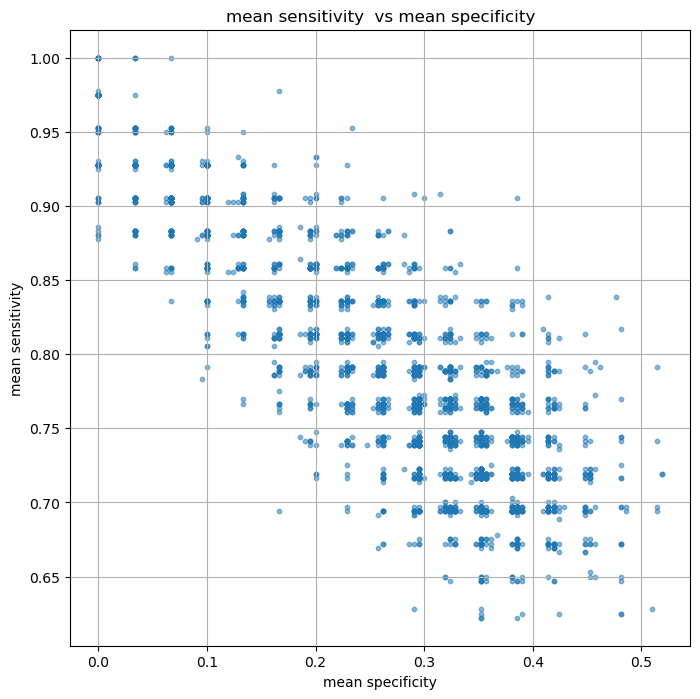

In [21]:
# create a scatter plot to explore best combination
def plotSensitivityVsSpecificity(df):
    w = 8
    h =  8 #10 #9 # 6 # 3
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(w, h), ) #sharey=True
    x = df.loc[:, 'specificity_mean']
    y = df.loc[:, 'sensitivity_mean']
    markerSize = 10
    axs.scatter(x, y, s=markerSize, alpha=0.5)

    axs.grid(True)

    axs.set_title( "mean sensitivity  vs mean specificity" )
    axs.set_xlabel( "mean specificity" )
    axs.set_ylabel( "mean sensitivity" )

    return (fig,axs)

sensitivityVsSpecificityFig, sensitivityVsSpecificityPandel = plotSensitivityVsSpecificity(rfhpDF)

## Create ROC and confusion matrix plots 
1. create models
2. train models
3. predict probablities
4. plot

**data model overview**  
a tree implemented as a dictionary of dictionaries
```
[specificity | sensitivity][LUAD | LUSC | Lung | All] [ model | predictedProbablities | predictions]
```

In [22]:
def createPlotDataDict(metrics : list[str], featureSets : list[str]) -> dict[dict]:
    plotDict = dict()

    for m in metrics:
        plotDict[m] = dict()
        for f in featureSets:
            plotDict[m][f] = dict()

    return plotDict

metrics = ['specificity', 'sensitivity']
# featureSets = ['LUAD', 'LUSC', 'Lung', 'All']
featureSets = ['Esophagus_Mucosa']
plotDict = createPlotDataDict(metrics, featureSets)   

In [23]:
def createRandomForestModels( hyperSearchResultsDict : dict[dict],
                              plotDict : dict[dict], 
                              metrics : list[str], 
                              featureSets : list[str],
                            AEDWIP_PYTHON_HACK : int = 999999999999):
    '''
    create random forest models . stores model in  plotDict[m][f]['model']
    parameters dictionary in  plotDict[m][f]['parameters']
    '''
    parameters = ['max_features', 'max_samples', 'n_estimators', 'max_depth']
    for m in metrics:
        for f in featureSets:
            rfhpDF = hyperSearchResultsDict[m][f]
            # kwags is a dictionary. Keys parameters. values are parameter values
            kwags= rfhpDF.loc[:, parameters].head(n=1).to_dict(orient="records")[0]

            # RandomForestClassifier expects default value for max_depth = None
            # data frame columns can not be mixed type. None is not an in
            if kwags['max_depth'] == AEDWIP_PYTHON_HACK:
                kwags['max_depth'] = None 

            if kwags['max_samples'] == AEDWIP_PYTHON_HACK:
                kwags['max_samples'] = None             

            # if kwags['max_samples']== 0:
            #     kwags['max_samples' = 1
                
            plotDict[m][f]['parameters'] = kwags
            print(f'\nm: {m} f: {f}\n{kwags}')
            model = RandomForestClassifier(**kwags)
            #print(f'model.max_samples : {model.max_samples} model.n_estimators : {model.n_estimators}')
            plotDict[m][f]['model'] = model
           
    

createRandomForestModels(hyperSearchResultsDict, plotDict, metrics, featureSets)


m: specificity f: Esophagus_Mucosa
{'max_features': 4, 'max_samples': 0.6, 'n_estimators': 50, 'max_depth': None}

m: sensitivity f: Esophagus_Mucosa
{'max_features': 1, 'max_samples': 0.1, 'n_estimators': 2000, 'max_depth': 1}


In [24]:
def trainModels( plotDict : dict[dict], 
                    metrics : list[str], 
                    featureSets : list[str],
                    XNP : np.array, 
                    yNP : np.array, 
               ):
    '''
    TODO

    fits model, 
    stores predictions in  
        plotDict[m][f]['predictions']  
        plotDict[m][f]['predictedProbablities']  
    '''
    for m in metrics:
        for f in featureSets:
            print(f"\nm: {m} f: {f} parameters:\n{plotDict[m][f]['parameters']}")
            model = plotDict[m][f]['model'] 
            model.fit(XNP, yNP)
            plotDict[m][f]['predictions'] = model.predict(XNP)
            plotDict[m][f]['predictedProbablities']    = model.predict_proba(XNP)

trainModels(plotDict, metrics, featureSets, XNP, yNP)


m: specificity f: Esophagus_Mucosa parameters:
{'max_features': 4, 'max_samples': 0.6, 'n_estimators': 50, 'max_depth': None}

m: sensitivity f: Esophagus_Mucosa parameters:
{'max_features': 1, 'max_samples': 0.1, 'n_estimators': 2000, 'max_depth': 1}


In [29]:
def plotROC(
        panel : plt.axes, 
        y : np.array,
        yProbability : np.array,
        title : str,
        classesToPlot=None
    ) :
    '''
    plotsROC:

    TODO pass/inject function to ROCPlotFramework

    arguments:
        y : ground truth labels
        yProbability : predicted labels probablity
    '''
    # https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_roc
    rocPanel = skplt.metrics.plot_roc(y, yProbability,
                                    title=title,
                                    title_fontsize = "medium",
                                    text_fontsize = "small",
                                    ax = panel,
                                    plot_micro=False,
                                    plot_macro=False,
                                    classes_to_plot=classesToPlot
                                    )
    # imgRocFilePath = imgOut + "/trainingROC.png"
    # print(imgFilePath)
    # fig =rocPanel.get_figure()
    # fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    # print(f'saving:\n{imgRocFilePath}')



In [26]:
def debugROCPlot():
    '''
    we have two labels, results in a plot wiht 2 cures. auc is the same
    Daniel asked that we only plot one curve
    '''
    print(plotDict.keys())
    # dict_keys(['specificity', 'sensitivity'])
    
    print(plotDict['specificity'].keys())
    #dict_keys(['Esophagus_Mucosa'])
    
    print(plotDict['specificity']['Esophagus_Mucosa'].keys())
    # dict_keys(['parameters', 'model', 'predictions', 'predictedProbablities'])
    
    print()
    
    # for key,item in plotDict['specificity']['Esophagus_Mucosa'].items():
    #     print(f'\nkey: {key} type(item) : {type(item)} \n{item}' )
    #     #print(f'\nkey: {key} ' )
    
    # predictions = [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
    #  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

    # predictions = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    #                0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    #                1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
    #                1, 1, 1, 1, 1, 1, 1, 1,]

    predictionsNP = plotDict['specificity']['Esophagus_Mucosa']['predictions']
    print(f'ground trueth    : 43 health control 31 esophagus cancer')
    print(f'len(predictionsNP) : {len(predictionsNP)} sum(predictionsNP) : {sum(predictionsNP)}')
    print(f'predictionsNP[0:5] : {predictionsNP[0:5]}')
    # print(f'predictionsNP[0:5] : {predictionsNP}')


    predictedProbablitiesNP =  plotDict['specificity']['Esophagus_Mucosa']['predictedProbablities']
    print( f'\npredictedProbablitiesNP[0:5] :\n{predictedProbablitiesNP[0:5]}' )
    # print( f'\npredictedProbablitiesNP[0:5] :\n{predictedProbablitiesNP[0:15]}' )

    byRow = 1
    print(f'\n np.max(predictedProbablitiesNP) : {np.max(predictedProbablitiesNP, axis=byRow)}')

    # 
    # only select prediction = 1. we only want to plot one class
    # knock predictedProbablitiesNP where ground trueth label = 0
    #
    # np.multiply elementwise
    # np.matmul matrix multiplication
    print(f'\n predictionsNP.shape : {predictionsNP.shape} predictedProbablitiesNP.shape : {predictedProbablitiesNP.shape}')
    # reshape (74,) to (74,1)
    knockOutNP = np.multiply( predictedProbablitiesNP,  np.reshape(predictionsNP, (74,1) )) 
    print(f'knockOutNP[0:5] : \n{knockOutNP[0:5]} ')

    # # Boolean indexing to filter out rows that are not [0, 0]
    predictedProbablitiesCat_1_NP= knockOutNP[~np.all(knockOutNP == [0, 0], axis=1)]
    print(f'predictedProbablitiesCat_1_NP shape: {predictedProbablitiesCat_1_NP.shape} predictedProbablitiesCat_1_NP[0:5] \n{predictedProbablitiesCat_1_NP[0:5]} ')

debugROCPlot()

dict_keys(['specificity', 'sensitivity'])
dict_keys(['Esophagus_Mucosa'])
dict_keys(['parameters', 'model', 'predictions', 'predictedProbablities'])

ground trueth    : 43 health control 31 esophagus cancer
len(predictionsNP) : 74 sum(predictionsNP) : 44
predictionsNP[0:5] : [0 0 0 0 0]

predictedProbablitiesNP[0:5] :
[[0.56 0.44]
 [0.56 0.44]
 [0.68 0.32]
 [0.76 0.24]
 [0.64 0.36]]

 np.max(predictedProbablitiesNP) : [0.56 0.56 0.68 0.76 0.64 0.78 0.56 0.64 0.66 0.74 0.58 0.84 0.8  0.78
 0.7  0.82 0.74 0.78 0.74 0.54 0.66 0.72 0.84 0.74 0.78 0.72 0.52 0.76
 0.56 0.52 0.58 0.84 0.7  0.6  0.86 0.74 0.92 0.92 0.88 0.92 0.78 0.66
 0.94 0.72 0.82 0.8  0.92 0.76 0.72 0.7  0.7  0.88 0.78 0.8  0.88 0.74
 0.64 0.76 0.78 0.62 0.86 0.76 0.66 0.86 0.54 0.68 0.94 0.72 0.92 0.82
 0.8  0.78 0.8  0.56]

 predictionsNP.shape : (74,) predictedProbablitiesNP.shape : (74, 2)
knockOutNP[0:5] : 
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] 
predictedProbablitiesCat_1_NP shape: (44, 2) predictedProbablitie

In [27]:
# def selectROCPlotDataForClassLabel_1(predictions : np.array, 
#                                      predictedProbablities: np.array) -> (np.array, np.array):
#     '''
#     plotDict['specificity']['Esophagus_Mucosa']['predictions'] is a 
#     np array of zeros and ones
#         [0 0 0 0 0]

#     plotDict['specificity']['Esophagus_Mucosa']['predictedProbablities'] is a 
#     np arra of zeros and ones. 
#             [[0.48 0.52]
#              [0.48 0.52]
#              [0.18 0.82]
#              [0.22 0.78]
#              [0.36 0.64]] 

#     by default ROCPlotFramework() would create a plot with two curves. One for
#     class == 0 , the other for class == 1. The curves are not identical how ever they
#     have the same area under the curve.

#     Daniel finds this confusing and asked we only plot one class

#     arguments:
#         prediction and predictedProbablities
#             see sample data above

#     returns:
#         (np.array, np.array)
#         the first array will be a np array of shape (n,1) where n is the 
#         number predicted items == 1

#         the second array will be the corresponding predict probablies for the examples/samples
#         that where predicted == 1. the shape will be (n,2)  
#     '''
#     # 
#     # create a knock vector that
#     # selects prediction for trueth = 1. we only want to plot one class
#     #

#     # reshape predictions, it probably has shape (n,). numpy can not broad cast
#     n = len(predictions)
#     predictionsNP = np.reshape(predictions, (n,1))
                                
#     # np.multiply elementwise
#     knockOutResultsNP = np.multiply( predictedProbablities,  predictionsNP ) 

#     # Boolean indexing to filter out rows that are not [0, 0]
#     positiveNP= knockOutResultsNP[~np.all(knockOutResultsNP == [0, 0], axis=1)]
#     print(f'AEDWIP positiveNP.shape {positiveNP.shape}')
#     numPositive = positiveNP.shape[0]

#     # the binary classifier returns 2 probablities for each example
#     # only return the probablity the example is "1"
#     retNP  = positiveNP[:,1].reshape(numPositive, 1)
#     return (np.ones(numPositive), retNP)

# ################################################################################
# def testSelectROCPlotDataForClassLabel_1() :
#     predictionsNP = np.array( [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0] )
#     print(f'predictionsNP: {predictionsNP.shape} {predictionsNP}')

#     predictedProbalibitesNP = np.array(
#                                 [[0.66, 0.34],
#                                  [0.5,  0.5 ],
#                                  [0.66, 0.34],
#                                  [0.52, 0.48],
#                                  [0.68, 0.32],
#                                  [0.74, 0.26],
#                                  [0.47, 0.53],
#                                  [0.66, 0.34],
#                                  [0.58, 0.42],
#                                  [0.88, 0.12],
#                                  [0.48, 0.52],
#                                  [0.9,  0.1 ]]
#                                 )
#                                 #  [0.78, 0.22],
#                                 #  [0.68, 0.32],
#                                 #  [0.8,  0.2 ]]
#                                 # )
#     print(f'\npredictedProbalibitesNP {predictedProbalibitesNP.shape} \n{predictedProbalibitesNP}')

#     retPredictions, resultNP = selectROCPlotDataForClassLabel_1(predictionsNP, predictedProbalibitesNP)
#     print(f'\nresultNP:\n{resultNP}')

#     expectedResultsNP = np.array(
#                             [[0.47, 0.53],
#                              [0.48, 0.52]]
#                             )

#     emsg = 'ERROR: test result do not match expected value'
#     np.testing.assert_array_equal(resultNP, expectedResultsNP, err_msg=emsg)
#     np.testing.assert_array_equal(retPredictions, np.ones(2), err_msg=emsg)

# testSelectROCPlotDataForClassLabel_1()    

numMetrics : 2
nRows : 1

i: 0 featureDataSetName : Esophagus_Mucosa
i : 0 j:0 metricName : specificity
i : 0 j:1 metricName : sensitivity
saving:
/private/groups/kimlab/aedavids/elife/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples.out/img/Elife_Random_Forest_best10CuratedDegree1_ce467ff_intracellular_biomarkers_best_hyperparameter_results.png
saving:
/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestIntraCellularEsophagusCancerBiomarkersOnExtracellularSamples/Elife_Random_Forest_best10CuratedDegree1_ce467ff_intracellular_biomarkers_best_hyperparameter_results.png


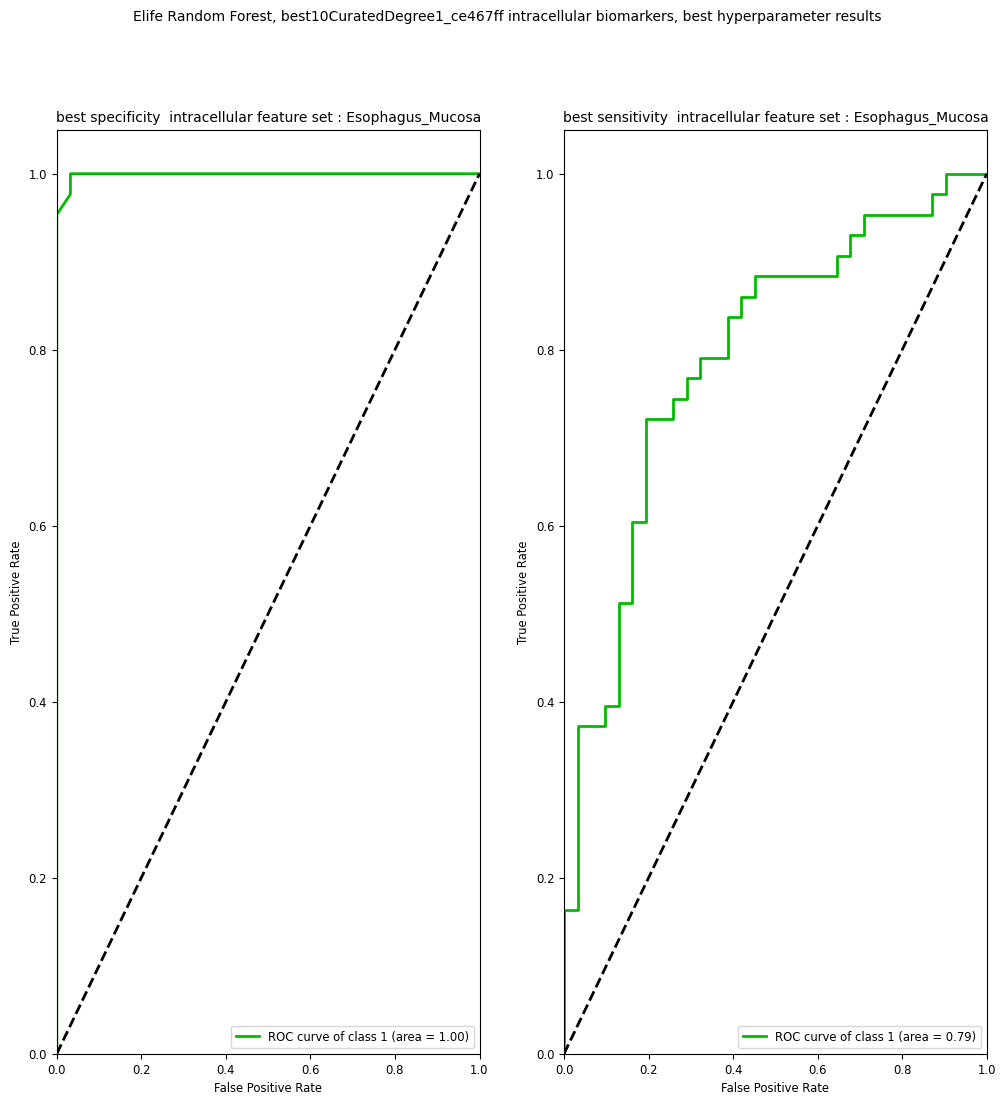

In [36]:
def ROCPlotFramework(
                    yNP : np.array,
                    plotDict : dict[dict], 
                    figTitle : str,
                    isBinaryResult : bool=False,
                    )-> tuple[plt.figure, list[plt.axes]] :
    '''
    TODO
    
    Create a panal of ROC curves. The number of columns = number of metrics.
    The number of rows = the number of feature data sets

    arguments:
        yNP :
            ground truth labels

        isBinaryResult:
            if true assumes predicted value are either zero or one. 
            Will only create a single ROC curve using example that where predicted
            to be 1. if False both 2 curves will be ploted. People may find this confusing
    '''

    groundTrueth = yNP
    
    metricsNames = list( plotDict.keys() )
    numMetrics = len(metricsNames)
    print(f'numMetrics : {numMetrics}')

    firstMetricKey = list(plotDict.keys())[0]
    featureDataSetNames = list( plotDict[firstMetricKey].keys() )
    nRows = len(featureDataSetNames)
    print(f'nRows : {nRows}')

    fs = 6 # 8  # fontsize
    w = 12
    h =  12 #10 #9 # 6 # 3
    fig, axs = plt.subplots(nrows=nRows, ncols=numMetrics, figsize=(w, h), ) #sharey=True
    #print(f'aedwip len(axs) : {len(axs)}')
    #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.subplots_adjust(hspace=0.5)
    
    for i in range(0, nRows):
        featureDataSetName = featureDataSetNames[i]
        print(f'\ni: {i} featureDataSetName : {featureDataSetName}')

        for j in range(0, numMetrics):
            metricName = metricsNames[j]
            print(f'i : {i} j:{j} metricName : {metricName}')

            title = f'best {metricName}  intracellular feature set : {featureDataSetName}'
            if nRows == 1:
                # 4/3/24: hack. we only have one feature class Esophagus_Mucosa
                # plt.subplot(1,3) returns a 1 dimensional itterator of axes
                panel = axs[j]
            else:
                panel = axs[i, j]

            groundTrueth = yNP
            yProbability = plotDict[metricName][featureDataSetName]['predictedProbablities'] 

            # default: plot all classes
            classes_to_plot = None
            
            if isBinaryResult : 
                # # predictions = plotDict[metricName][featureDataSetName]['predictions']
                # # print(f'\nAEDWIP predictions {type(predictions)} {predictions.shape}')
                # # groundTrueth, yProbability = selectROCPlotDataForClassLabel_1(predictions, yProbability)
                # # print(f'groundTrueth {type(groundTrueth)} {groundTrueth.shape}')
                # # print(f'groundTrueth {groundTrueth}')
                # # print(f'yProbability {type(yProbability)} {yProbability.shape}')
                # # print(f'yProbability {yProbability} ')
                # yProbability = yProbability[:,1]
                # print(f'yProbability {type(yProbability)} {yProbability.shape}')
                # print(f'yProbability {yProbability} ')
                classes_to_plot = [1]
            plotROC( panel, 
                    groundTrueth, 
                    yProbability,
                    title,
                    classesToPlot = classes_to_plot
            )
    
    fig.suptitle(figTitle, fontsize="medium")
    return (fig, axs)

################################################################################
title = 'Elife Random Forest, best10CuratedDegree1_ce467ff intracellular biomarkers, best hyperparameter results'
fig, axs = ROCPlotFramework(yNP, plotDict, title, isBinaryResult=True)

# save img close to ipynb file
file = "Elife_Random_Forest_best10CuratedDegree1_ce467ff_intracellular_biomarkers_best_hyperparameter_results.png"
imgFilePath = f'{imgOut}/{file}'
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saving:\n{imgFilePath}')

# save a copy along with rest of hyperparmeter results
rfHyperparemeterOut= "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"
tmpOutDir = f'{rfHyperparemeterOut}/{notebookName}'
os.makedirs(tmpOutDir, exist_ok=True)
imgFilePath = f'{tmpOutDir}/{file}'
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
print(f'saving:\n{imgFilePath}')
